## Training the Vision Transformer on a Custom Dataset

In this notebook, we are going to fine-tune a pre-trained Vision Transformer (which can be found from [Huggingface](https://github.com/huggingface/transformers)) on a Custom Dataset. For this notebook we will be using the Rock, Paper, Scissors dataset which can be found [here](https://public.roboflow.com/classification/rock-paper-scissors/1). This dataset is a collection of 2925 images images in 3 different classes. This tutorial is based on Huggingface's [Fine tuning the Vision Transformer on CIFAR 10 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train the HuggingFace Vision Transformer On a Custom Dataset](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) concurrently.


We will prepare the data using [Roboflow's Preprocessing Tools](https://docs.roboflow.com/image-transformations/image-preprocessing), and train the model using this notebook.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train a Vision Transformer on your custom classification data.

To train our image classifier we take the following steps:

* Install Vision Transformer dependencies
* Download custom Image Classification data using Roboflow
* Use the Vision Transformer Feature Extractor
* Run the Vision Transformer training procedure
* Evaluate the Vision Transformer on a test image
* Export the Vision Transformer model for future inference


### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



Let's start by installing the relevant libraries.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download the Data

We'll preprocess and download our dataset from Roboflow. To preprocess the images, change the size of the image to 224x224. To download the dataset, use the "**Folder Structure**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

Note: This data has already been preprocessed through Roboflow; we HIGHLY reccommend you follow the [accompanying blog](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) as you go through this notebook.

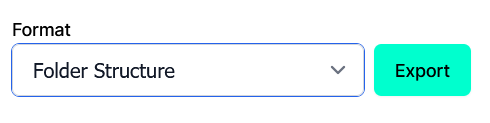

In [2]:
!curl -L "https://app.roboflow.com/ds/R7gpdcipl4?key=Xm9ErGiWSB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
 extracting: train/taban/050445_zappos_20170723_8900308_image0004_jpg.rf.e553a337d92d3ca65318c2fa9ca32775.jpg  
 extracting: train/taban/050445_zappos_20170723_8900308_image0005_jpg.rf.e0cddc77768cd60d26ea3887105367d0.jpg  
 extracting: train/taban/050453_zappos_20170723_8973543_image0000_jpg.rf.8121202141c32fe4fe189fe07a366dc8.jpg  
 extracting: train/taban/050470_6pm_20180529_9098519_image0000_jpg.rf.598b5de31bf7ad8f31dca5a341aa1e20.jpg  
 extracting: train/taban/050470_zappos_20170723_8893014_image0000_jpg.rf.7d67e0acbd1f774ec05669484c92a7be.jpg  
 extracting: train/taban/050482_zappos_20170723_8928335_image0000_jpg.rf.297d3561b22df19f53e547c216e227f4.jpg  
 extracting: train/taban/050482_zappos_20170723_8928335_image0002_jpg.rf.73f4b0336c766538eb6697f96ab7cef4.jpg  
 extracting: train/taban/050487_zappos_20170723_8956672_image0000_jpg.rf.29b2350c876273f289cf98a9986f5055.jpg  
 extracting: train/taban/050510_6pm_20180529_8899848_image00

Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

In [4]:
!rm -rf /content/train/.ipynb_checkpoints
!rm -rf /content/valid/.ipynb_checkpoints
!rm -rf /content/test/.ipynb_checkpoints # Test klasöründe de olabilir, tedbir amaçlı

In [5]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/content/train/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/content/valid/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/content/test/', transform=ToTensor())

## Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [6]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

## Define the Model Parameters

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [7]:
EPOCHS = 3
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [8]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Train the Model

In [ ]:
import torch
import torch.utils.data as data
# from torch.autograd import Variable # Modern PyTorch'ta genellikle gerekli değil
import numpy as np

# ----- BU DEĞİŞKENLERİN TANIMLI OLDUĞUNDAN EMİN OLUN -----
# Örnek değerler (kendi projenize göre güncelleyin):
# BATCH_SIZE = 32
# EPOCHS = 10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torchvision ve ToTensor zaten import edilmiş varsayılıyor.
# from torchvision.transforms import ToTensor
# import torchvision
# train_ds = torchvision.datasets.ImageFolder('/content/train/', transform=ToTensor())
# test_ds = torchvision.datasets.ImageFolder('/content/test/', transform=ToTensor())

# feature_extractor = ... # Örnek: ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', do_rescale=False)
# model = ... # Modeliniz tanımlanmış ve device'a gönderilmiş olmalı (örn: model.to(device))
# loss_func = ... # Örneğin: torch.nn.CrossEntropyLoss() # Bu bir TENSOR döndürmeli
# optimizer = ... # Örneğin: torch.optim.Adam(model.parameters(), lr=0.001)
# -------------------------------------------------------------

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

# DataLoader'ları drop_last=True ile oluşturuyoruz
train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_loader = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True) # Testte shuffle=False ve drop_last=True

# Eğer "It looks like you are trying to rescale already rescaled images." uyarısı alıyorsanız:
# feature_extractor'ınızı oluştururken veya çağırırken `do_rescale=False` parametresini ekleyin.
# Örnek:
# from transformers import ViTFeatureExtractor
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k', do_rescale=False)

# Train the model
for epoch in range(EPOCHS):
    model.train() # Modeli eğitim moduna al
    running_train_loss_sum = 0.0 # Epoch boyunca toplam kayıp
    num_train_batches = 0

    for step, (images, labels) in enumerate(train_loader):
        # images: [BATCH_SIZE, C, H, W] formatında bir PyTorch tensorü
        # labels: [BATCH_SIZE] formatında bir PyTorch tensorü

        # Görüntüleri feature_extractor'a uygun hale getirme
        try:
            # `do_rescale=False` burada da eklenebilir eğer extractor oluşturulurken eklenmediyse
            processed_images = feature_extractor(images, return_tensors="pt")['pixel_values']
        except TypeError as e:
            print(f"Uyarı: Feature extractor tensor batch ile çalışmıyor olabilir, liste denenecek. Hata: {e}")
            image_list_for_fe = [img.numpy() for img in images]
            processed_images_data = feature_extractor(image_list_for_fe)['pixel_values']
            processed_images = torch.tensor(np.stack(processed_images_data, axis=0))

        b_images = processed_images.to(device)
        b_labels = labels.to(device)

        # Modelden çıktı ve potansiyel olarak loss al
        # Modelinizin `forward` metodunun loss'u bir TENSOR olarak döndürdüğünden emin olun
        # veya sadece `output` döndürüyorsa `loss_func` kullanın.
        output_logits, loss_from_model = model(b_images, b_labels) # Model etiketleri alıp loss hesaplıyorsa
        # VEYA: output_logits, _ = model(b_images, None) # Eğer model sadece logits döndürüyorsa ve etiketleri forward'da almıyorsa

        # Calculate loss (loss_for_backward bir TENSOR olmalı)
        if loss_from_model is not None and isinstance(loss_from_model, torch.Tensor):
            loss_for_backward = loss_from_model
        elif loss_func is not None:
            loss_for_backward = loss_func(output_logits, b_labels) # Bu bir TENSOR döndürmeli
        else:
            raise ValueError("Ne model ne de loss_func bir kayıp TENSOR'u sağlamadı.")

        # `loss_for_backward`'ın bir tensor olduğunu kontrol edelim (opsiyonel debug)
        if not isinstance(loss_for_backward, torch.Tensor):
            print(f"HATA: loss_for_backward bir tensor değil! Tipi: {type(loss_for_backward)}")
            # Burada programı durdurabilir veya bir hata fırlatabilirsiniz
            # raise TypeError("loss_for_backward bir PyTorch Tensor olmalıdır.")

        optimizer.zero_grad()
        loss_for_backward.backward() # Şimdi `loss_for_backward` bir TENSOR olduğu için çalışmalı
        optimizer.step()

        running_train_loss_sum += loss_for_backward.item() # .item() SADECE loglama/toplama için burada kullanılır
        num_train_batches += 1

        if step > 0 and step % 50 == 0:
            model.eval()
            with torch.no_grad():
                try:
                    test_batch_data = next(iter(test_loader))
                    test_images, test_labels = test_batch_data[0], test_batch_data[1]
                except StopIteration:
                    print(f"Epoch {epoch}, Step {step}: Test loader tükendi, bu adımda test atlanıyor.")
                    model.train()
                    continue

                try:
                    processed_test_images = feature_extractor(test_images, return_tensors="pt")['pixel_values']
                except TypeError:
                    test_image_list_for_fe = [img.numpy() for img in test_images]
                    processed_test_images_data = feature_extractor(test_image_list_for_fe)['pixel_values']
                    processed_test_images = torch.tensor(np.stack(processed_test_images_data, axis=0))

                b_test_images = processed_test_images.to(device)
                b_test_labels = test_labels.to(device)

                test_output_logits, test_loss_from_model = model(b_test_images, b_test_labels)

                current_test_loss_tensor = None
                if test_loss_from_model is not None and isinstance(test_loss_from_model, torch.Tensor):
                    current_test_loss_tensor = test_loss_from_model
                elif loss_func is not None:
                    current_test_loss_tensor = loss_func(test_output_logits, b_test_labels)

                test_loss_value_for_print = current_test_loss_tensor.item() if current_test_loss_tensor is not None else float('nan')

                predicted_classes = test_output_logits.argmax(1)
                accuracy = (predicted_classes == b_test_labels).sum().item() / BATCH_SIZE # drop_last=True sayesinde

                print(f'Epoch: {epoch} | Step: {step} | Batch Train Loss: {loss_for_backward.item():.4f} | Test Accuracy: {accuracy:.2f} | Test Loss: {test_loss_value_for_print:.4f}')
            model.train()

    avg_epoch_train_loss = running_train_loss_sum / num_train_batches if num_train_batches > 0 else float('nan')
    print(f"Epoch {epoch} finished. Average Training Loss: {avg_epoch_train_loss:.4f}")

print("Eğitim tamamlandı.")

# İsteğe bağlı: Modelin son bir genel test performansı (tüm test seti üzerinde)
model.eval()
total_test_correct = 0
total_test_samples = 0
running_final_test_loss_sum = 0.0
num_final_test_batches = 0

# Final test için drop_last=False ile tüm test verisini kullanmak daha doğru olabilir.
final_test_loader = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

with torch.no_grad():
    for test_images, test_labels in final_test_loader:
        actual_batch_size = test_images.shape[0]

        try:
            processed_test_images = feature_extractor(test_images, return_tensors="pt")['pixel_values']
        except TypeError:
            test_image_list_for_fe = [img.numpy() for img in test_images]
            processed_test_images_data = feature_extractor(test_image_list_for_fe)['pixel_values']
            processed_test_images = torch.tensor(np.stack(processed_test_images_data, axis=0))

        b_test_images = processed_test_images.to(device)
        b_test_labels = test_labels.to(device)

        final_test_output_logits, final_test_loss_from_model = model(b_test_images, b_test_labels)

        current_final_test_loss_tensor = None
        if final_test_loss_from_model is not None and isinstance(final_test_loss_from_model, torch.Tensor):
            current_final_test_loss_tensor = final_test_loss_from_model
        elif loss_func is not None:
            current_final_test_loss_tensor = loss_func(final_test_output_logits, b_test_labels)

        if current_final_test_loss_tensor is not None:
            running_final_test_loss_sum += current_final_test_loss_tensor.item() * actual_batch_size # Ağırlıklı toplama
        num_final_test_batches +=1


        predicted_classes = final_test_output_logits.argmax(1)
        total_test_correct += (predicted_classes == b_test_labels).sum().item()
        total_test_samples += actual_batch_size

if total_test_samples > 0:
    final_accuracy = total_test_correct / total_test_samples
    # Eğer her batch için loss toplandıysa ve ağırlıklı ortalama isteniyorsa:
    final_avg_test_loss = running_final_test_loss_sum / total_test_samples if total_test_samples > 0 else float('nan')
    # Alternatif: Eğer her batch'in loss'unu toplayıp batch sayısına bölecekseniz (drop_last=False ile daha az doğru):
    # final_avg_test_loss = running_final_test_loss_sum / num_final_test_batches if num_final_test_batches > 0 else float('nan')
    print(f"\n--- Final Test Sonuçları ---")
    print(f"Toplam Test Örneği: {total_test_samples}")
    print(f"Genel Test Doğruluğu: {final_accuracy:.4f}")
    print(f"Ortalama Test Kaybı (ağırlıklı): {final_avg_test_loss:.4f}")
else:
    print("Final test için hiç örnek işlenemedi.")

Number of train samples:  3888
Number of test samples:  555
Detected Classes are:  {'taban': 0, 'yan': 1}
Epoch: 0 | Step: 50 | Batch Train Loss: 0.6675 | Test Accuracy: 1.00 | Test Loss: 0.4917
Epoch: 0 | Step: 100 | Batch Train Loss: 0.6788 | Test Accuracy: 1.00 | Test Loss: 0.4534
Epoch: 0 | Step: 150 | Batch Train Loss: 0.6134 | Test Accuracy: 1.00 | Test Loss: 0.4449
Epoch: 0 | Step: 200 | Batch Train Loss: 0.7315 | Test Accuracy: 1.00 | Test Loss: 0.4546


## Evaluate on a Test Image

Finally, let's evaluate the model on a test image:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4)
# Disable grad
with torch.no_grad():

  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)

  # Generate prediction
  prediction, loss = model(inputs, target)

  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]

  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

## Save the Entire Model

We can save the entire model as follows:

In [ ]:
torch.save(model, '/content/model.pt')

## Export Trained Model

Now that you have trained your custom vision transformer, you can export the trained model you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/model.pt /content/gdrive/My\ Drive

## Use your Exported Model

In [ ]:
MODEL_PATH = '/content/model.pt'
model = torch.load(MODEL_PATH)
model.eval()